## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [49]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import decimal
from itertools import chain
import sklearn.model_selection as skl
from random import sample
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Lambda
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import scipy.stats
from sklearn.model_selection import train_test_split

import math    
import skimage
from skimage import io
from keras.applications.vgg16 import preprocess_input
from keras.models import model_from_json
from keras.layers import Dense, Dropout, Flatten




## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
88678,00021972_014.png,Atelectasis|Infiltration|Nodule,14,21972,49,F,AP,3056,2544,0.139,0.139,NaN,/data/images_010/images/00021972_014.png
33615,00008814_010.png,Atelectasis|Effusion|Infiltration,10,8814,36,M,PA,2992,2991,0.143,0.143,NaN,/data/images_004/images/00008814_010.png
93959,00023769_000.png,Infiltration,0,23769,40,F,PA,2770,2885,0.143,0.143,NaN,/data/images_010/images/00023769_000.png


In [3]:
# Remove the 'Unnamed: 11' since it only contains Null values
df_xray_clean = all_xray_df.drop('Unnamed: 11', axis=1)
df_xray_clean.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800


In [4]:
df_xray_clean = df_xray_clean[df_xray_clean['Patient Age'] <= 100]
df_xray_clean['Patient Age'].describe()


count    112104.000000
mean         46.872574
std          16.598152
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max          95.000000
Name: Patient Age, dtype: float64

In [5]:
all_labels = np.unique(list(chain(*df_xray_clean['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        df_xray_clean[c_label] = df_xray_clean['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
df_xray_clean.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
56173,00014005_003.png,No Finding,3,14005,72,M,PA,3056,2504,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
78138,00019176_048.png,Effusion|Infiltration,48,19176,66,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
24904,00006542_000.png,No Finding,0,6542,70,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [6]:
df_xray_clean['pneumonia_class'] = df_xray_clean.Pneumonia == 1


In [7]:
df_xray_clean['pneumonia_class'], df_xray_clean['pneumonia_class'].mean()


(0         False
 1         False
 2         False
 3         False
 4         False
           ...  
 112115     True
 112116    False
 112117    False
 112118    False
 112119    False
 Name: pneumonia_class, Length: 112104, dtype: bool,
 0.012756012274316705)

## Create your training and testing data:

In [8]:
def create_splits(df, test_size=0.2, random_state=42):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # First, split the train and validation data and ensure that a ratio of
    # positive cases of pneumonia_class are the same in both datasets
    train_data, val_data = train_test_split(df, 
                                   test_size = test_size, 
                                   stratify = df['pneumonia_class'], 
                                   random_state = random_state)
    
    # Next, ensure that we have EQUAL amount of positive and negative cases of pneumonia_class 
    # in Training
    p_inds_train = train_data[train_data.pneumonia_class == 1].index.tolist()
    np_inds_train = train_data[train_data.pneumonia_class == 0].index.tolist()

    np_sample_train = sample(np_inds_train,len(p_inds_train))
    train_data = train_data.loc[p_inds_train + np_sample_train]
    

    p_inds_val = val_data[val_data.pneumonia_class == 1].index.tolist()
    np_inds_val = val_data[val_data.pneumonia_class == 0].index.tolist()
    
    # Number of negative cases will be 4 times greater that the positive cases
    np_sample_val = sample(np_inds_val, 4 * len(p_inds_val))
    val_data = val_data.loc[p_inds_val + np_sample_val]
    
    return train_data, val_data

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [9]:
def my_image_augmentation(horizontal_flip = True,
                          height_shift_range = 0.05,
                          width_shift_range = 0.1,
                          rotation_range = 5, 
                          shear_range = 0.1,
                          zoom_range = 0.05):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # preprocess_input function is used to ensured that the data format is suitable for the
    # pretrained vgg16 in keras
    # See the following post for more details:
    # https://stackoverflow.com/questions/47555829/preprocess-input-method-in-keras/47556342#47556342
        
    idg = ImageDataGenerator(rescale = 1. / 255.0,
                              horizontal_flip = horizontal_flip, 
                              vertical_flip = False, 
                              height_shift_range = height_shift_range, 
                              width_shift_range = width_shift_range, 
                              rotation_range = rotation_range, 
                              shear_range = shear_range,
                              zoom_range = zoom_range,
                              preprocessing_function = preprocess_input)
    
    return idg



def make_train_gen(df, IMG_SIZE = (224, 224), batch_size = 128):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo

    idg = my_image_augmentation()
    train_gen = idg.flow_from_dataframe(dataframe=df_xray_clean, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'raw',
                                         shuffle = True,
                                         target_size = IMG_SIZE, 
                                         batch_size = batch_size
                                         )

    return train_gen


def make_val_gen(df, IMG_SIZE = (224, 224), batch_size = 128, shuffle=True):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    idg = ImageDataGenerator(rescale = 1. / 255.0,
                             preprocessing_function = preprocess_input)
    val_gen = idg.flow_from_dataframe(dataframe=df_xray_clean, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'raw',
                                         target_size = IMG_SIZE, 
                                         batch_size = batch_size,
                                         shuffle = shuffle
                                         )
    
    
    # Todo
    return val_gen


In [10]:
train_data, val_data = create_splits(df_xray_clean)


In [11]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(val_data)

valX, valY = val_gen.next()

Found 112104 validated image filenames.


In [12]:
train_gen = make_train_gen(train_data)


Found 112104 validated image filenames.


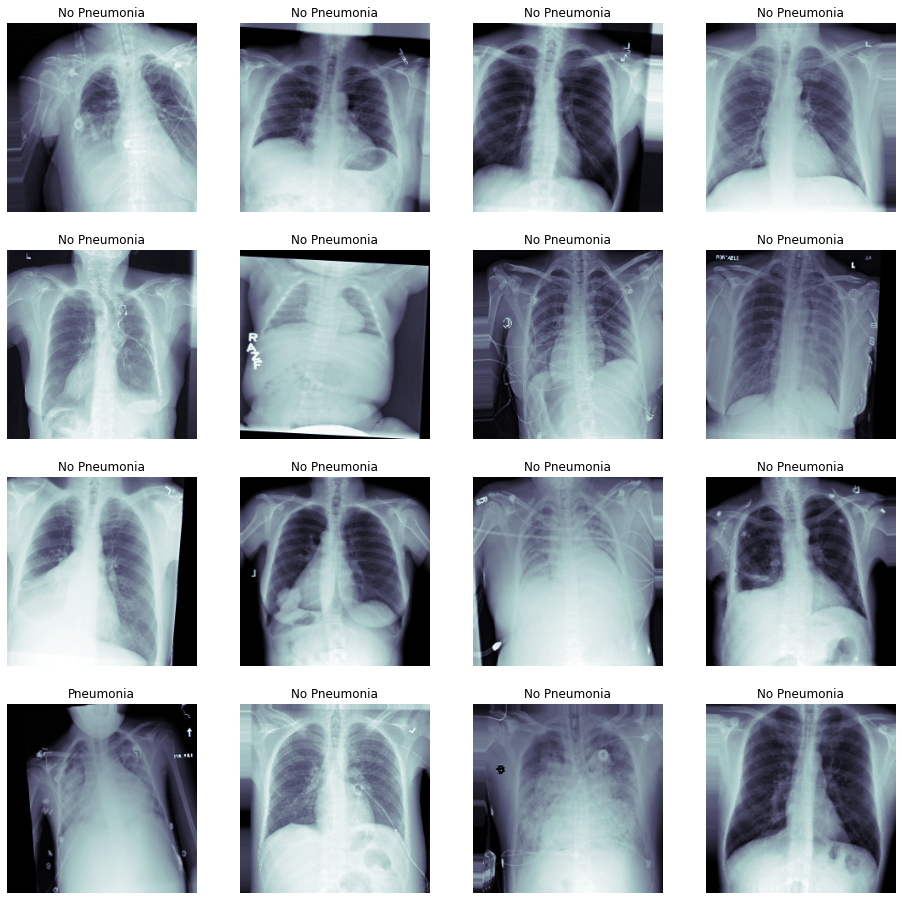

In [13]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [14]:
def load_pretrained_model():
    
    # Use the pre-trained vgg16 for this transfer learning task
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    pretrained_model = Model(inputs=model.input,
                       outputs=transfer_layer.output)

    for layer in pretrained_model.layers[0:17]:
        layer.trainable = False    
    
    return pretrained_model

In [15]:
def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    new_model = Sequential()

    # Add the convolutional part of the pretrained model.
    pretrainedModel = load_pretrained_model()
    new_model.add(pretrainedModel)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    new_model.add(Flatten())

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(0.5))
    
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.3))
    
    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dropout(0.3))

    # Last Layer -> Output a single value
    new_model.add(Dense(1, activation='sigmoid'))
    
    
    return new_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [16]:
## Set our optimizer, loss function, and learning rate
my_model = build_my_model()
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

553467904/553467096 [==============================] - 2s 0us/step


In [17]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

# Monitor a training loss for this task since the validation loss is very fluctuated in this task
checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'loss', 
                      mode= 'min', 
                      patience=10)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.25,
                                  patience=3, min_lr=1e-5)

callbacks_list = [checkpoint, early, reduce_lr]

### Start training! 

In [31]:
history = my_model.fit_generator(train_gen, 
                                steps_per_epoch=50,
                              validation_data = (valX, valY), 
                              epochs = 100, 
                              callbacks = callbacks_list)

Epoch 1/100
50/50 [==============================] - 166s 3s/step - loss: 0.0683 - binary_accuracy: 0.9881 - val_loss: 0.1108 - val_binary_accuracy: 0.9766

Epoch 00001: loss did not improve from 0.06241
Epoch 2/100
50/50 [==============================] - 164s 3s/step - loss: 0.0824 - binary_accuracy: 0.9853 - val_loss: 0.1127 - val_binary_accuracy: 0.9766

Epoch 00002: loss did not improve from 0.06241
Epoch 3/100
50/50 [==============================] - 167s 3s/step - loss: 0.0687 - binary_accuracy: 0.9882 - val_loss: 0.1121 - val_binary_accuracy: 0.9766

Epoch 00003: loss did not improve from 0.06241
Epoch 4/100
50/50 [==============================] - 166s 3s/step - loss: 0.0669 - binary_accuracy: 0.9889 - val_loss: 0.1114 - val_binary_accuracy: 0.9766

Epoch 00004: loss did not improve from 0.06241
Epoch 5/100
50/50 [==============================] - 164s 3s/step - loss: 0.0748 - binary_accuracy: 0.9873 - val_loss: 0.1115 - val_binary_accuracy: 0.9766

Epoch 00005: loss did not i

In [51]:
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 1000, verbose = True)

128/128 [==============================] - 1s 6ms/step


##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [38]:
def plot_auc(t_y, p_y):
    '''
    Plot a ROC curve and also display the AUC value
    '''
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    # https://towardsdatascience.com/10-minutes-to-building-a-fully-connected-binary-image-classifier-in-tensorflow-d88062e1247f

    fpr, tpr, _ = roc_curve(t_y, p_y)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1-Specificity)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    
    def plot_precision_recall_curve(t_y, p_y):
        '''
        Plot a Precision-Recall curve and also display the average Precision score
        '''
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.set_title('Precision-Recall curve')
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    return precision, recall, thresholds
    
# function to calculate the F1 score
def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
   
    fig, m_axs = plt.subplots(1,2, figsize = (12, 4))
    m_axs[0].plot(history.history['loss'], label = "Training Loss")
    m_axs[0].plot(history.history['val_loss'], label = "Validation Loss")
    m_axs[0].set(xlabel='Epoch', ylabel='Loss')
    m_axs[0].set_yscale('log')
    m_axs[0].legend()
    m_axs[0].set_title('Training Loss vs Validation Loss');
    
   

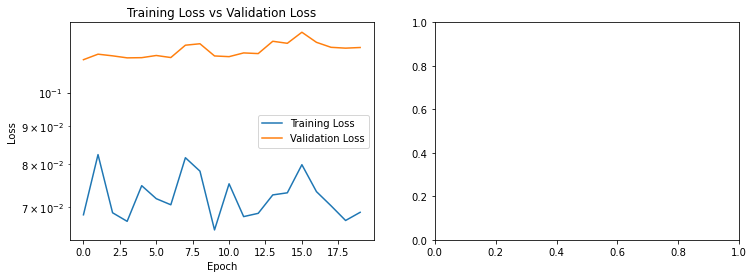

In [39]:
# Log scale
plot_history(history)

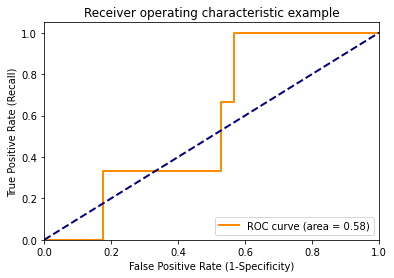

(array([0.04054054, 0.02739726, 0.02777778, 0.02816901, 0.02857143,
        0.02898551, 0.02941176, 0.01492537, 0.01515152, 0.01538462,
        0.015625  , 0.01587302, 0.01612903, 0.01639344, 0.01666667,
        0.01694915, 0.01724138, 0.01754386, 0.01785714, 0.01818182,
        0.01851852, 0.01886792, 0.01923077, 0.01960784, 0.02      ,
        0.02040816, 0.02083333, 0.0212766 , 0.02173913, 0.02222222,
        0.02272727, 0.02325581, 0.02380952, 0.02439024, 0.025     ,
        0.02564103, 0.02631579, 0.02702703, 0.02777778, 0.02857143,
        0.02941176, 0.03030303, 0.03125   , 0.03225806, 0.03333333,
        0.03448276, 0.03571429, 0.03703704, 0.03846154, 0.04      ,
        0.04166667, 0.04347826, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

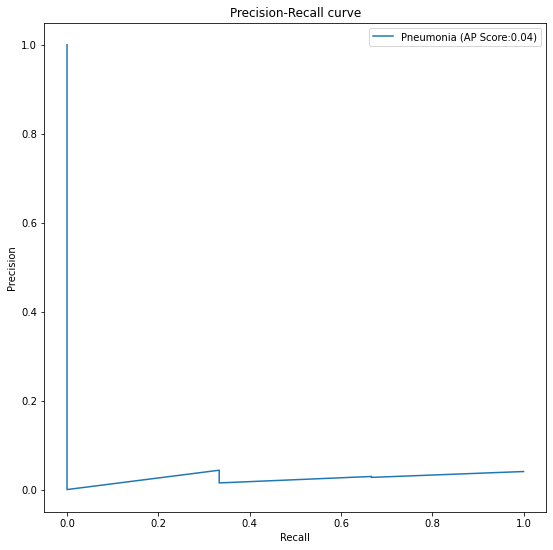

In [40]:
# ROC Curve
plot_auc(valY, pred_Y)

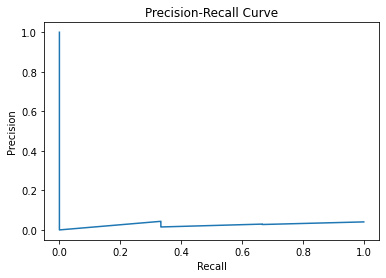

In [52]:
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

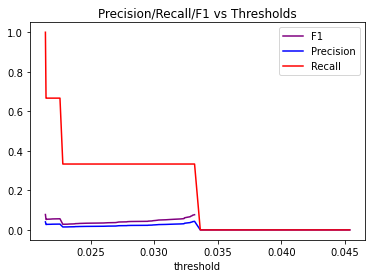

In [54]:
plt.plot(thresholds, all_f1[:-1], color='purple', label="F1")
plt.plot(thresholds, precision[:-1], color='blue', label="Precision")
plt.plot(thresholds, recall[:-1], color='red', label="Recall")

plt.legend()
plt.title('Precision/Recall/F1 vs Thresholds')
plt.xlabel('threshold');

In [56]:
thresh = 0.85
testY = valY

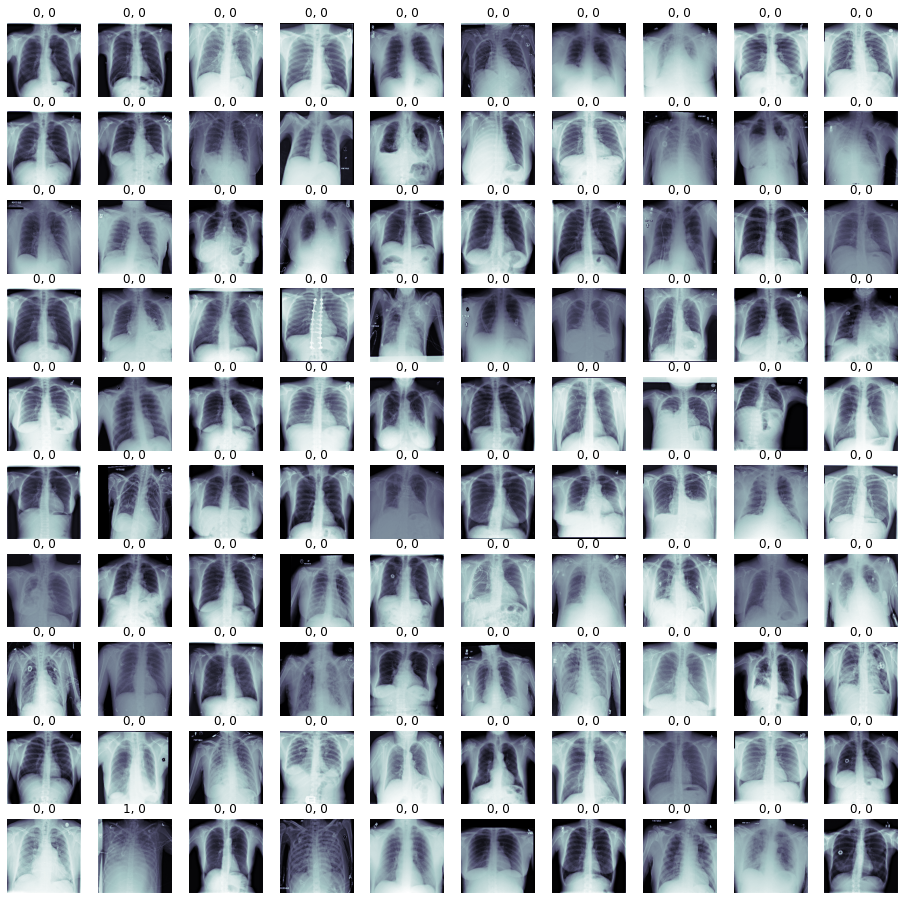

In [58]:
val_ground_truth = [] 
val_out = []

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
    val_ground_truth.append(c_y)
    val_out.append(pred_Y[i] > thresh)
    
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > thresh:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > thresh: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [60]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)